In [1]:
import os
import sys
import fitsio
import pylab as pl 
import numpy as np
import astropy.io.fits as fits

from   astropy.table import Table, join
from   desitarget.sv3 import sv3_targetmask
from   matplotlib.pyplot import figure
from   scipy.optimize import curve_fit

In [2]:
sys.path.append('/global/homes/m/mjwilson/desi/BGS/lumfn/py/lumfn/')
sys.path.append('/global/homes/m/mjwilson/desi/BGS/lumfn/py/')

In [3]:
from   distances import comoving_distance, comoving_volume
from   tmr_kcorr import tmr_kcorr
from   abs_mag import abs_mag
from   vmax import zmax, vmax

In [4]:
# Targeting info. cut to (enlarged) area around rosettes.
targ = Table.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/bright_targets.fits')
targ

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_EPOCH,WISEMASK_W1,WISEMASK_W2,MASKBITS,LC_FLUX_W1 [15],LC_FLUX_W2 [15],LC_FLUX_IVAR_W1 [15],LC_FLUX_IVAR_W2 [15],LC_NOBS_W1 [15],LC_NOBS_W2 [15],LC_MJD_W1 [15],LC_MJD_W2 [15],SHAPE_R,SHAPE_E1,SHAPE_E2,SHAPE_R_IVAR,SHAPE_E1_IVAR,SHAPE_E2_IVAR,SERSIC,SERSIC_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,SV3_SCND_TARGET,HPXPIXEL,NUMOBS_MORE,NUMOBS,Z,ZWARN,ZTILEID,TARGET_STATE,TIMESTAMP,VERSION,PRIORITY
int16,int32,bytes8,int32,bytes4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,int16,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,float64,int64,int32,bytes18,bytes25,bytes14,int64
9011,509983,2169p327,600,REX,216.80629663482495,532442700000.0,32.86539133128327,540718920000.0,56049.76 .. 0.0,0.009019313,3.8787324,11.307069,19.326576,363.63123,251.2709,60.94878,0.97365427,0.9821759,0.98999053,0.005416837,0.0123046655,0.003427037,0.0008861267,0.0016587465,0.0056556086,0.99991864,0.9998678,0.9999118,3,10,4,742.29803,375.10876,136.53345,543.05133,304.94852,78.84412,26.21095,18.155811,122.46539,-874.7276,3.5702417,0.9939347,0.0024024008,2.9312083e-05,0.9984727,0.99906176,0.99979985,0.9999244,0,0,0,1.8634341,5.432181,9.28494,1.8643541,5.435047,9.288813,0.0,0,0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.5512292,0.0,0.0,38960.336,0.0,0.0,1.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,N,39632936135295576,1152921504606846976,265,0,0.7400881364731525,516,102100,9,0,9146,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:09,0.57.0,102100
9011,509983,2169p327,872,PSF,216.82329511100102,2487243200000000.0,32.853605676201354,1397064100000000.0,946839.6 .. 0.0,0.009165708,42.361206,61.565556,66.82184,99.76457,128.3293,63.029854,0.9732324,0.98188925,0.9898289,1.847135e-06,5.014069e-06,-8.4143906e-08,9.840272e-05,0.00011875074,0.18202144,0.7507431,0.75001335,1.0001361,3,6,4,626.91486,325.1054,136.53345,461.87598,262.12387,78.84412,16.829653,10.015994,32.404163,-86.31498,4.1102996,1.1258,0.002402661,2.8279761e-05,0.9984479,0.9990465,0.99979657,0.99992317,0,0,0,32.55593,47.315083,51.354706,32.55593,47.315083,51.354706,2015.5,0,0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0,

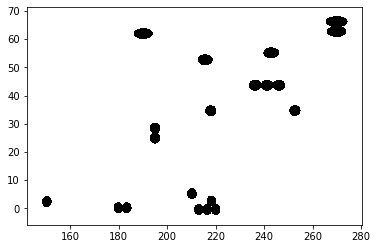

In [5]:
pl.plot(targ['RA'], targ['DEC'], lw=0.0, marker=',', c='k')

In [6]:
# rosette = targ[targ['RA'] < 160.]
# rosette

In [7]:
# pl.plot(rosette['RA'], rosette['DEC'], lw=0.0, marker=',', c='k')

In [8]:
# Cut to only BGS bright of available targets.
bgs_bright = targ[(sv3_targetmask.bgs_mask['BGS_BRIGHT'] & targ['SV3_BGS_TARGET']) != 0]
bgs_bright

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_EPOCH,WISEMASK_W1,WISEMASK_W2,MASKBITS,LC_FLUX_W1 [15],LC_FLUX_W2 [15],LC_FLUX_IVAR_W1 [15],LC_FLUX_IVAR_W2 [15],LC_NOBS_W1 [15],LC_NOBS_W2 [15],LC_MJD_W1 [15],LC_MJD_W2 [15],SHAPE_R,SHAPE_E1,SHAPE_E2,SHAPE_R_IVAR,SHAPE_E1_IVAR,SHAPE_E2_IVAR,SERSIC,SERSIC_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,SV3_SCND_TARGET,HPXPIXEL,NUMOBS_MORE,NUMOBS,Z,ZWARN,ZTILEID,TARGET_STATE,TIMESTAMP,VERSION,PRIORITY
int16,int32,bytes8,int32,bytes4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,int16,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,float64,int64,int32,bytes18,bytes25,bytes14,int64
9011,509983,2169p327,1688,SER,216.88116092657143,1032087540000.0,32.83068341574189,1570192400000.0,205723.11 .. 268795.22,0.008447082,20.356531,39.113518,60.873184,110.39328,97.40892,19.978071,0.97530496,0.9832972,0.9906226,0.001759964,0.0029730955,0.0012036024,0.00018735876,0.00037655208,0.00063520053,0.99996156,0.9999271,0.9999488,3,6,3,626.91486,325.1054,96.783356,461.87598,262.12387,57.419968,59.00676,51.785526,426.4162,622.49805,2.572068,0.78060675,0.002056326,2.5805577e-05,0.9985695,0.99912125,0.99981254,0.9999292,0,0,0,5.249605,10.086715,15.698165,5.250172,10.087823,15.699688,0.0,0,0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,1.3568981,-0.20899639,-0.04612831,62882.73,149085.06,83183.82,1.2353296,3000.343,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,N,39632936135296664,1152921504606846976,514,0,0.9329852418335539,516,102100,9,0,9146,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:05:09,0.57.0,102100
9011,509983,2169p327,2074,REX,216.90978827249847,1264422600000.0,32.855990581965735,1146379300000.0,145774.31 .. 0.0,0.008269792,19.391104,27.466742,35.192146,131.26096,128.44746,37.531723,0.97581697,0.98364496,0.9908185,0.07049748,0.08372872,0.06797205,0.00029093254,0.00061139464,0.023538565,0.99999076,0.9999854,0.99999565,3,6,4,626.91486,325.1054,136.53345,461.87598,262.12387,78.84412,24.744066,14.618888,314.00116,-282.55978,3.5335982,1.0113343,0.0022576058,2.8062377e-05,0.99859947,0.99913967,0.9998165,0.9999307,0,0,0,6.5806212,9.321193,11.942909,6.74726,9.593498,12.314225,0.0,0,0,0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .

In [9]:
del targ 

In [10]:
np.unique(bgs_bright['PRIORITY_INIT'], return_counts=True)

(<Column name='PRIORITY_INIT' dtype='int64' length=1>
 102100,
 array([170042]))

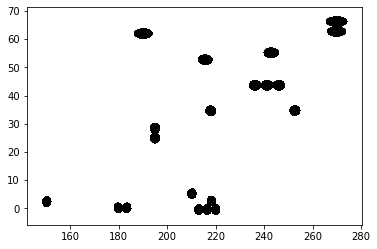

In [11]:
pl.plot(bgs_bright['RA'], bgs_bright['DEC'], lw=0.0, marker=',', c='k')

In [12]:
# Get the available bright targets.  Cut to BGS bright based on TARGETID. 
bright_reachable = Table.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/datcomb_bright_tarwdup_Alltiles.fits')
bright_reachable = bright_reachable[np.isin(bright_reachable['TARGETID'], bgs_bright['TARGETID'])]
bright_reachable

RA,DEC,REF_EPOCH,PARALLAX,PMRA,PMDEC,TARGETID,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,NUMOBS_MORE,NUMOBS,Z,ZWARN_MTL,ZTILEID,TARGET_STATE,TIMESTAMP,VERSION,PRIORITY,FIBER,LOCATION,TILEID
float64,float64,float32,float32,float32,float32,int64,float64,int32,int64,int64,int64,int64,float64,int64,int32,bytes30,bytes25,bytes14,int64,int32,int32,int64
212.07059399316668,-2.1573886448277855,0.0,0.0,0.0,0.0,39627733927462321,0.7011759117301452,516,102100,9,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,102100,506,1462,526
212.07059399316668,-2.1573886448277855,0.0,0.0,0.0,0.0,39627733927462321,0.7011759117301452,516,102100,9,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,102100,523,1463,532
212.07182231138097,-2.1576366940231786,0.0,0.0,0.0,0.0,39627733927462346,0.7155266907459459,516,102100,9,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,102100,523,1463,532
212.07182231138097,-2.1576366940231786,0.0,0.0,0.0,0.0,39627733927462346,0.7155266907459459,516,102100,9,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,102100,506,1462,526
212.09545449057381,-2.1473580348689323,0.0,0.0,0.0,0.0,39627733927462847,0.2791055154660187,516,102100,9,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,102100,523,1463,532
212.09545449057381,-2.1473580348689323,0.0,0.0,0.0,0.0,39627733927462847,0.2791055154660187,516,102100,9,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,102100,508,1441,526
212.13195284744052,-2.1397232701515705,0.0,0.0,0.0,0.0,39627733927463584,0.3064671342899772,516,102100,9,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,102100,515,1442,532
212.13195284744052,-2.1397232701515705,0.0,0.0,0.0,0.0,39627733927463584,0.3064671342899772,516,102100,9,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,102100,524,1464,529
212.14293772910978,-2.127708100431868,0.0,0.0,0.0,0.0,39627733927463809,0.9682231030567523,516,102100,9,9,0,-1.0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,102100,524,1464,529


In [13]:
np.unique(bright_reachable['PRIORITY_INIT'])

102100


In [14]:
# Target can be reached by multiple fibers.
len(bright_reachable), len(np.unique(bright_reachable['TARGETID']))

(1368481, 162671)

In [15]:
# bright_reachable.dtype.names

In [16]:
# Available spectroscopic catalogs.
# bright_spec = Table.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/daily/datcomb_bright_specwdup_Alltiles.fits')
# bright_spec = bright_spec[(sv3_targetmask.bgs_mask['BGS_BRIGHT'] & bright_spec['SV3_BGS_TARGET']) != 0] # includes sky. 
# bright_spec = bright_spec[bright_spec['OBJTYPE'] == 'TGT']
# bright_spec

In [17]:
# left outer join of reachable targets and spectro.
# cut to BGS Bright. 
bright_merge = Table.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/daily/datcomb_bright_tarspecwdup_Alltiles.fits')
bright_merge = bright_merge[(sv3_targetmask.bgs_mask['BGS_BRIGHT'] & bright_merge['SV3_BGS_TARGET']) != 0]
bright_merge

RA,DEC,REF_EPOCH,PARALLAX,PMRA,PMDEC,TARGETID,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,NUMOBS_MORE,NUMOBS,ZWARN_MTL,ZTILEID,TARGET_STATE,TIMESTAMP,VERSION,LOCATION,TILEID,TILELOCID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,FIBER,FIBERSTATUS,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,DELTA_X,DELTA_Y,EXPTIME,PSF_TO_FIBER_SPECFLUX,NIGHT,EXPID,MJD,INTEG_COADD_FLUX_B,MEDIAN_COADD_FLUX_B,MEDIAN_COADD_SNR_B,INTEG_COADD_FLUX_R,MEDIAN_COADD_FLUX_R,MEDIAN_COADD_SNR_R,INTEG_COADD_FLUX_Z,MEDIAN_COADD_FLUX_Z,MEDIAN_COADD_SNR_Z,TSNR2_ELG_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_ELG_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_ELG_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_ELG,TSNR2_LYA,TSNR2_BGS,TSNR2_QSO,TSNR2_LRG,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET
float64,float64,float32,float32,float32,float32,int64,float64,int32,int64,int64,int64,int64,int64,int32,bytes30,bytes25,bytes14,int64,int64,int64,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int32,int32,bytes3,float32,float32,int32,float64,float64,float64,float64,int32,int32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,int64
212.07059399316668,-2.1573886448277855,0.0,0.0,0.0,0.0,39627733927462321,0.7011759117301452,516,102100,9,9,0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,1462,526,5261462,1e+20,1e+20 .. 1e+20,1e+20,1e+20,999999,999999,N/A,N/A,999999,1e+20,999999,999999,N/A,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1152921504606846976,131074,0
212.07059399316668,-2.1573886448277855,0.0,0.0,0.0,0.0,39627733927462321,0.7011759117301452,516,102100,9,9,0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,1463,532,5321463,1e+20,1e+20 .. 1e+20,1e+20,1e+20,999999,999999,N/A,N/A,999999,1e+20,999999,999999,N/A,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1152921504606846976,131074,0
212.07182231138097,-2.1576366940231786,0.0,0.0,0.0,0.0,39627733927462346,0.7155266907459459,516,102100,9,9,0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,1463,532,5321463,8691.917048618197,110.1924173269175 .. -13.909760857702603,0.20831738790192758,3.870861964601318e-05,0,7886,GALAXY,,10,300.0186497028917,523,0,TGT,175.50546,-366.08752,102100,-0.004,0.001,329.2138,0.7514636097863017,20210512,88162,59347.28192359,2494.5547,1.495369,1.2990925,4100.856,2.2913628,3.9154603,4768.7817,2.1793647,4.723067,0.013547539,7.073917,109.063484,0.39787793,0.16146766,5.505917,0.007272676,489.47827,0.8947302,7.7659473,18.000463,0.0,1035.9039,4.453982,9.583865,23.519928,7.0811896,1634.4458,5.74659,17.51128,1152921504606846976,131074,0
212.07182231138097,-2.1576366940231786,0.0,0.0,0.0,0.0,39627733927462346,0.7155266907459459,516,102100,9,9,0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,1462,526,5261462,1e+20,1e+20 .. 1e+20,1e+20,1e+20,999999,999999,N/A,N/A,999999,1e+20,999999,999999,N/A,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1152921504606846976,131074,0
212.09545449057381,-2.1473580348689323,0.0,0.0,0.0,0.0,39627733927462847,0.2791055154660187,516,102100,9,9,0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,1441,526,5261441,1e+20,1e+20 .. 1e+20,1e+20,1e+20,999999,999999,N/A,N/A,999999,1e+20,999999,999999,N/A,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,999999,999999,

In [18]:
# Check merge has same number of targets as those reachable.
len(bright_merge), len(bright_reachable)

(1368481, 1368481)

In [19]:
# Check that those with spectro. is merge matches number in spectro catalog. 
# len(bright_spec), np.count_nonzero(bright_merge['ZWARN'].data != 999999)

In [20]:
# Limit to spectro. observations on a working fiber.
bright_merge_obs = bright_merge[(bright_merge['ZWARN'].data != 999999) & (bright_merge['FIBERSTATUS'] == 0)]
bright_merge_obs

RA,DEC,REF_EPOCH,PARALLAX,PMRA,PMDEC,TARGETID,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,NUMOBS_MORE,NUMOBS,ZWARN_MTL,ZTILEID,TARGET_STATE,TIMESTAMP,VERSION,LOCATION,TILEID,TILELOCID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,FIBER,FIBERSTATUS,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,DELTA_X,DELTA_Y,EXPTIME,PSF_TO_FIBER_SPECFLUX,NIGHT,EXPID,MJD,INTEG_COADD_FLUX_B,MEDIAN_COADD_FLUX_B,MEDIAN_COADD_SNR_B,INTEG_COADD_FLUX_R,MEDIAN_COADD_FLUX_R,MEDIAN_COADD_SNR_R,INTEG_COADD_FLUX_Z,MEDIAN_COADD_FLUX_Z,MEDIAN_COADD_SNR_Z,TSNR2_ELG_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_ELG_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_ELG_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_ELG,TSNR2_LYA,TSNR2_BGS,TSNR2_QSO,TSNR2_LRG,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET
float64,float64,float32,float32,float32,float32,int64,float64,int32,int64,int64,int64,int64,int64,int32,bytes30,bytes25,bytes14,int64,int64,int64,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int32,int32,bytes3,float32,float32,int32,float64,float64,float64,float64,int32,int32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,int64
212.07182231138097,-2.1576366940231786,0.0,0.0,0.0,0.0,39627733927462346,0.7155266907459459,516,102100,9,9,0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,1463,532,5321463,8691.917048618197,110.1924173269175 .. -13.909760857702603,0.20831738790192758,3.870861964601318e-05,0,7886,GALAXY,,10,300.0186497028917,523,0,TGT,175.50546,-366.08752,102100,-0.004,0.001,329.2138,0.7514636097863017,20210512,88162,59347.28192359,2494.5547,1.495369,1.2990925,4100.856,2.2913628,3.9154603,4768.7817,2.1793647,4.723067,0.013547539,7.073917,109.063484,0.39787793,0.16146766,5.505917,0.007272676,489.47827,0.8947302,7.7659473,18.000463,0.0,1035.9039,4.453982,9.583865,23.519928,7.0811896,1634.4458,5.74659,17.51128,1152921504606846976,131074,0
212.13195284744052,-2.1397232701515705,0.0,0.0,0.0,0.0,39627733927463584,0.3064671342899772,516,102100,9,9,0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,1442,532,5321442,8181.238723360002,650.8494234496903 .. 26.321080977338845,0.18489118881349448,8.151114524677556e-05,0,7898,GALAXY,,10,121.69535649672616,515,0,TGT,159.9167,-360.7208,102100,-0.003,-0.0,329.2138,0.7250493309558984,20210512,88162,59347.28192359,2839.2163,1.7219174,1.4668155,4295.8286,2.4269316,4.082689,5179.0156,2.3733006,4.9972258,0.013628212,7.094321,109.622696,0.40032744,0.16285975,5.484065,0.007271832,486.65622,0.8906726,7.714434,17.933203,0.0,1025.0463,4.4246182,9.502515,23.430895,7.1015925,1621.3252,5.7156186,17.379808,1152921504606846976,131074,0
212.14293772910978,-2.127708100431868,0.0,0.0,0.0,0.0,39627733927463809,0.9682231030567523,516,102100,9,9,0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,1464,529,5291464,8649.267828658223,482.3641546970651 .. 28.304609010743402,0.18572600120311122,5.0569333051126286e-05,0,7825,GALAXY,,10,491.2810438387096,524,0,TGT,174.46136,-357.95212,102100,0.007,-0.013,836.0849,0.7045758604118871,20210507,87604,59342.33186133,5241.1284,3.161646,2.7221062,9271.688,5.1619253,7.320931,11833.8,5.418451,9.364234,0.014638815,7.937166,115.9185,0.43463737,0.16990733,4.3820224,0.005671774,385.05923,0.70937586,6.173186,13.938504,0.0,734.8787,3.2962127,7.0799737,18.335165,7.942838,1235.8564,4.440226,13.423067,1152921504606846976,131074,0
212.1818402755797,-2.172762494351842,0.0,0.0,0.0,0.0,39627733927464616,0.03133156253842562,575,102100,3,0,1,0,526,BGS|MORE_ZGOOD,2021-05-04T19:41:03,0.57.1,1462,529,5291462,10138.8015223369,2590.275448610141 .. 321.1439460016381,0.054284603945268343,1.7884827870871947e-05,0,7861,GALAXY,,10,2104.479461349547,506,0,TGT,164.81406,-369.82938,2,0.014,-0.01,836.0849,0.6953723451668198,20210507,87604,59342.33186133,18420.898,10.84

In [21]:
np.unique(bright_merge_obs['PRIORITY'].data)

array([     2,  82100,  92100, 102100], dtype=int32)

In [22]:
# Add fluxes & colors. 
bright_merge_obs                    = join(bright_merge_obs, bgs_bright['FIBERFLUX_R', 'FLUX_G', 'FLUX_R', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'TARGETID'], join_type='left', keys='TARGETID')

In [23]:
bright_merge_obs['GMAG']            = 22.5 - 2.5 * np.log10(bright_merge_obs['FLUX_G']) 
bright_merge_obs['GMAG_DRED']       = 22.5 - 2.5 * np.log10(bright_merge_obs['FLUX_G'] / bright_merge_obs['MW_TRANSMISSION_G']) 

bright_merge_obs['RMAG']            = 22.5 - 2.5 * np.log10(bright_merge_obs['FLUX_R']) 
bright_merge_obs['RMAG_DRED']       = 22.5 - 2.5 * np.log10(bright_merge_obs['FLUX_R'] / bright_merge_obs['MW_TRANSMISSION_R']) 

bright_merge_obs['FIBER_RMAG']      = 22.5 - 2.5 * np.log10(bright_merge_obs['FIBERFLUX_R']) 
bright_merge_obs['FIBER_RMAG_DRED'] = 22.5 - 2.5 * np.log10(bright_merge_obs['FIBERFLUX_R'] / bright_merge_obs['MW_TRANSMISSION_R']) 

In [24]:
bright_merge_obs['GMR']             = bright_merge_obs['GMAG'] - bright_merge_obs['RMAG']
bright_merge_obs['GMR_DRED']        = bright_merge_obs['GMAG_DRED'] - bright_merge_obs['RMAG_DRED']

Text(0.5, 0, '$r$')

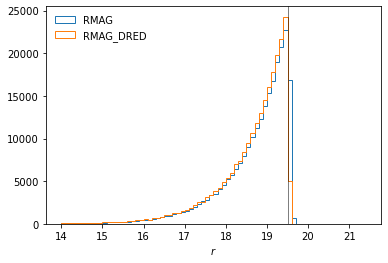

In [25]:
_                                   = pl.hist(bright_merge_obs['RMAG'], bins=np.arange(14., 21.5, 0.1), histtype='step', label='RMAG')
_                                   = pl.hist(bright_merge_obs['RMAG_DRED'], bins=np.arange(14., 21.5, 0.1), histtype='step', label='RMAG_DRED')

pl.legend(frameon=False, loc=2)
pl.axvline(19.5, lw=0.5, c='k')
pl.xlabel('$r$')

Text(0.5, 0, 'fiber $r$')

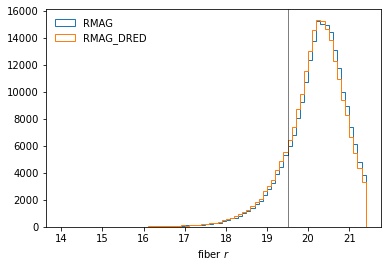

In [26]:
_                             = pl.hist(bright_merge_obs['FIBER_RMAG'], bins=np.arange(14., 21.5, 0.1), histtype='step', label='RMAG')
_                             = pl.hist(bright_merge_obs['FIBER_RMAG_DRED'], bins=np.arange(14., 21.5, 0.1), histtype='step', label='RMAG_DRED')

pl.legend(frameon=False, loc=2)

pl.axvline(19.5, lw=0.5, c='k')
pl.xlabel('fiber $r$')

In [27]:
# Limit to first observation.  Subsequent observations reassigned on the basis of a bad first redshift.  
# Check: is this true only of dark time?  Doubtful.
bright_merge_obs = bright_merge_obs[bright_merge_obs['PRIORITY'] > 3000]
bright_merge_obs

RA,DEC,REF_EPOCH,PARALLAX,PMRA,PMDEC,TARGETID,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,NUMOBS_MORE,NUMOBS,ZWARN_MTL,ZTILEID,TARGET_STATE,TIMESTAMP,VERSION,LOCATION,TILEID,TILELOCID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,FIBER,FIBERSTATUS,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,DELTA_X,DELTA_Y,EXPTIME,PSF_TO_FIBER_SPECFLUX,NIGHT,EXPID,MJD,INTEG_COADD_FLUX_B,MEDIAN_COADD_FLUX_B,MEDIAN_COADD_SNR_B,INTEG_COADD_FLUX_R,MEDIAN_COADD_FLUX_R,MEDIAN_COADD_SNR_R,INTEG_COADD_FLUX_Z,MEDIAN_COADD_FLUX_Z,MEDIAN_COADD_SNR_Z,TSNR2_ELG_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_ELG_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_ELG_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_ELG,TSNR2_LYA,TSNR2_BGS,TSNR2_QSO,TSNR2_LRG,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,FIBERFLUX_R,FLUX_G,FLUX_R,MW_TRANSMISSION_G,MW_TRANSMISSION_R,GMAG,GMAG_DRED,RMAG,RMAG_DRED,FIBER_RMAG,FIBER_RMAG_DRED,GMR,GMR_DRED
float64,float64,float32,float32,float32,float32,int64,float64,int32,int64,int64,int64,int64,int64,int32,bytes30,bytes25,bytes14,int64,int64,int64,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int32,int32,bytes3,float32,float32,int32,float64,float64,float64,float64,int32,int32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
212.07182231138097,-2.1576366940231786,0.0,0.0,0.0,0.0,39627733927462346,0.7155266907459459,516,102100,9,9,0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,1463,532,5321463,8691.917048618197,110.1924173269175 .. -13.909760857702603,0.20831738790192758,3.870861964601318e-05,0,7886,GALAXY,,10,300.0186497028917,523,0,TGT,175.50546,-366.08752,102100,-0.004,0.001,329.2138,0.7514636097863017,20210512,88162,59347.28192359,2494.5547,1.495369,1.2990925,4100.856,2.2913628,3.9154603,4768.7817,2.1793647,4.723067,0.013547539,7.073917,109.063484,0.39787793,0.16146766,5.505917,0.007272676,489.47827,0.8947302,7.7659473,18.000463,0.0,1035.9039,4.453982,9.583865,23.519928,7.0811896,1634.4458,5.74659,17.51128,1152921504606846976,131074,0,6.5144067,5.435668,15.029476,0.8395581,0.88887244,20.661867,20.471994,19.55764,19.429739,20.465313,20.337412,1.1042271,1.0422554
212.13195284744052,-2.1397232701515705,0.0,0.0,0.0,0.0,39627733927463584,0.3064671342899772,516,102100,9,9,0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,1442,532,5321442,8181.238723360002,650.8494234496903 .. 26.321080977338845,0.18489118881349448,8.151114524677556e-05,0,7898,GALAXY,,10,121.69535649672616,515,0,TGT,159.9167,-360.7208,102100,-0.003,-0.0,329.2138,0.7250493309558984,20210512,88162,59347.28192359,2839.2163,1.7219174,1.4668155,4295.8286,2.4269316,4.082689,5179.0156,2.3733006,4.9972258,0.013628212,7.094321,109.622696,0.40032744,0.16285975,5.484065,0.007271832,486.65622,0.8906726,7.714434,17.933203,0.0,1025.0463,4.4246182,9.502515,23.430895,7.1015925,1621.3252,5.7156186,17.379808,1152921504606846976,131074,0,6.960086,14.839426,41.38945,0.83804214,0.8877909,19.571457,19.379622,18.457775,18.328552,20.393463,20.26424,1.1136818,1.0510693
212.14293772910978,-2.127708100431868,0.0,0.0,0.0,0.0,39627733927463809,0.9682231030567523,516,102100,9,9,0,-1,-1,BGS|UNOBS,2021-04-04T23:14:10,0.57.0,1464,529,5291464,8649.267828658223,482.3641546970651 .. 28.304609010743402,0.18572600120311122,5.0569333051126286e-05,0,7825,GALAXY,,10,491.2810438387096,524,0,TGT,174.46136,-357.95212,102100,0.007,-0.013,836.0849,0.7045758604118871,20210507,87604,59342.33186133,5241.1284,3.161646,2.7221062,9271.688,5.1619253,7.320931,11833.8,5.418451,9.364234,0.014638815,7.937166,115.9185,0.43463737,0.16990733,4.3820224,0.005671774,385.05923,0.70937586,6.173186,13.938504,0.0,734.8787,3.2962127,7.0799737,18.335165,7

In [28]:
bright_merge_obs['BGS_Z_SUCCESS'] = (bright_merge_obs['ZWARN'] == 0) & (bright_merge_obs['DELTACHI2'] > 40.)

In [29]:
bright_merge_obs['TSNR_IDX'] = np.trunc(bright_merge_obs['TSNR2_BGS'].data / 60.)

In [30]:
bright_merge_obs_grouped = bright_merge_obs.group_by('TSNR_IDX')
bright_merge_obs_binned  = bright_merge_obs_grouped['TSNR2_BGS', 'BGS_Z_SUCCESS'].groups.aggregate(np.mean)
bright_merge_obs_binned.sort('TSNR2_BGS')

Text(0, 0.5, 'BGS $z$ Success')

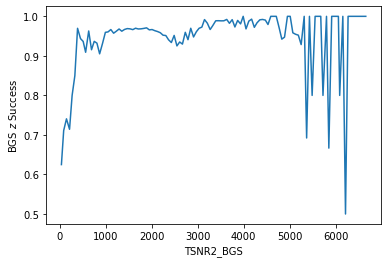

In [31]:
pl.plot(bright_merge_obs_binned['TSNR2_BGS'], bright_merge_obs_binned['BGS_Z_SUCCESS'])

pl.xlabel('TSNR2_BGS')
pl.ylabel('BGS $z$ Success')

In [32]:
bright_merge_obs['RMAG_IDX'] = np.digitize(bright_merge_obs['FIBER_RMAG'], bins=np.arange(19.5, 22., 0.2))

In [33]:
bright_merge_obs_grouped = bright_merge_obs.group_by(['RMAG_IDX'])
bright_merge_obs_binned  = bright_merge_obs_grouped['TSNR2_BGS', 'FIBER_RMAG', 'RMAG', 'RMAG_DRED', 'RMAG_IDX', 'TSNR_IDX', 'BGS_Z_SUCCESS'].groups.aggregate(np.mean)

In [34]:
bright_merge_obs_binned.sort('FIBER_RMAG')

In [35]:
def zsuccess(rfiber, a=2.68, b=22.113):
    return 1. /  (1. + np.exp(a * (rfiber - b)))

In [36]:
curve_fit(zsuccess, bright_merge_obs_binned['FIBER_RMAG'], bright_merge_obs_binned['BGS_Z_SUCCESS'], p0=[1.31, 22.3])

(array([ 2.68042704, 22.11306185]),
 array([[ 0.00781561, -0.00069397],
        [-0.00069397,  0.00021691]]))

(-0.05, 1.05)

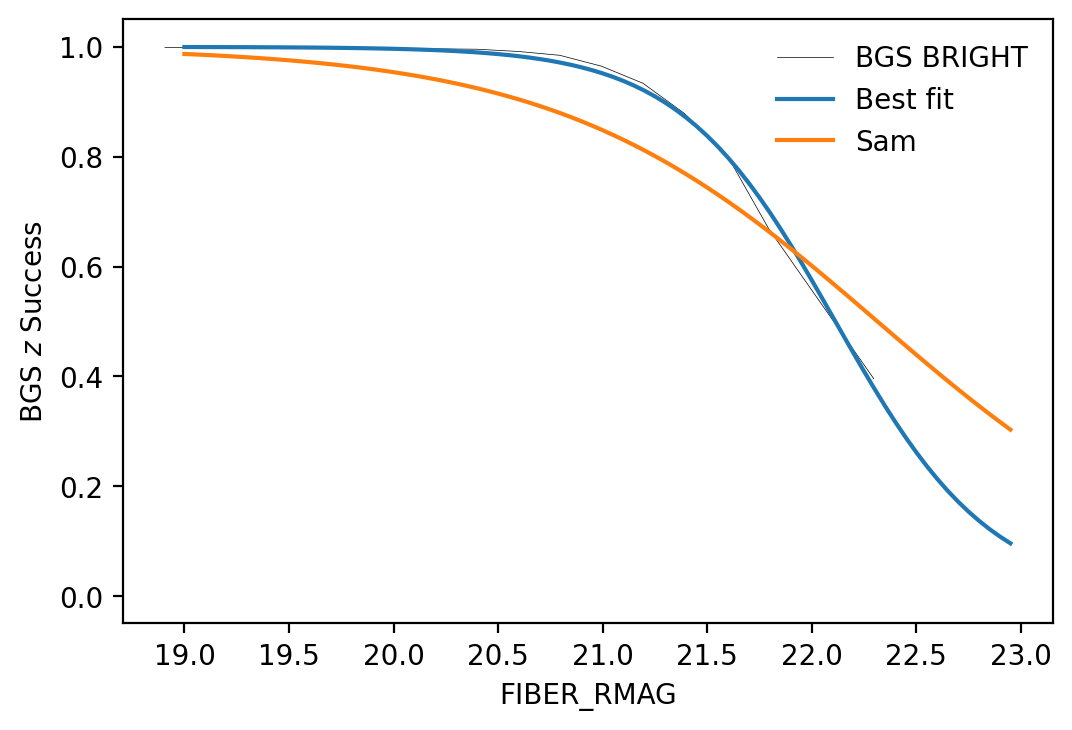

In [37]:
figure(figsize=(6, 4), dpi=200)

xs = np.arange(19.0, 23.0, 0.05)

pl.plot(bright_merge_obs_binned['FIBER_RMAG'], bright_merge_obs_binned['BGS_Z_SUCCESS'], c='k', lw=0.25, label='BGS BRIGHT')

pl.plot(xs, zsuccess(xs), label='Best fit')
pl.plot(xs, zsuccess(xs, a=1.31, b=22.314), label='Sam')

pl.xlabel('FIBER_RMAG')
pl.ylabel('BGS $z$ Success')

pl.legend(frameon=False, loc=1)

pl.ylim(-0.05, 1.05)

In [38]:
bright_merge_obs['BGS_Z_WEIGHT'] = 1. / zsuccess(bright_merge_obs['FIBER_RMAG'])

In [39]:
bright_merge_obs['RMAG_IDX']     = np.digitize(bright_merge_obs['FIBER_RMAG'], bins=np.arange(19.5, 22., 1.0))

In [40]:
bright_merge_obs_grouped         = bright_merge_obs.group_by(['TSNR_IDX', 'RMAG_IDX'])
bright_merge_obs_binned          = bright_merge_obs_grouped['TSNR2_BGS', 'FIBER_RMAG', 'RMAG', 'RMAG_DRED', 'RMAG_IDX', 'BGS_Z_SUCCESS'].groups.aggregate(np.mean)

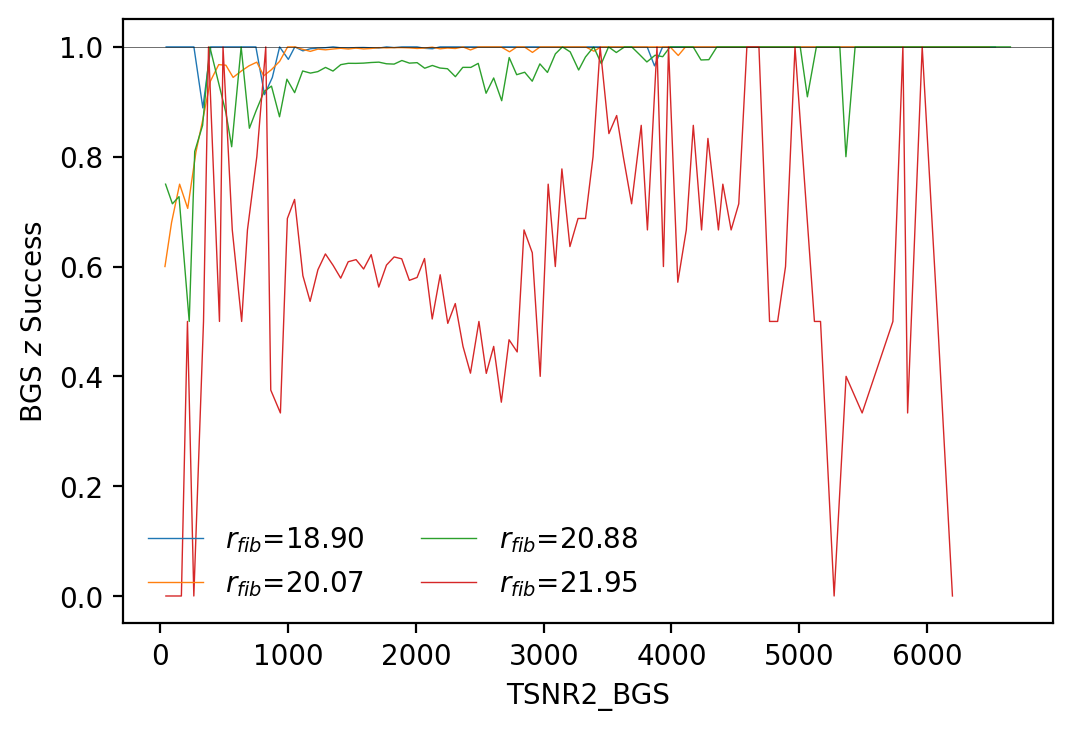

In [41]:
figure(figsize=(6, 4), dpi=200)

for idx in np.unique(bright_merge_obs_binned['RMAG_IDX'].data):
    sel = bright_merge_obs_binned['RMAG_IDX'] == idx
    
    label = '$r_{fib}$' + '={:.2f}'.format(np.mean(bright_merge_obs_binned['FIBER_RMAG'][sel]))
    
    pl.plot(bright_merge_obs_binned['TSNR2_BGS'][sel], bright_merge_obs_binned['BGS_Z_SUCCESS'][sel], alpha=1., lw=0.5, label=label)

pl.axhline(1.0, lw=0.2, c='k')
    
pl.xlabel('TSNR2_BGS')
pl.ylabel('BGS $z$ Success')

pl.legend(frameon=False, loc=3, ncol=2)

In [42]:
kcorrector = tmr_kcorr()

In [43]:
len(bright_merge_obs)

158311

In [44]:
# 300 km/s lower limit for stars; upper limit due to extrapolation of k correction. 
bright_merge_cat = bright_merge_obs[(bright_merge_obs['Z'] >= 0.001) & (bright_merge_obs['Z'] <= 0.5)]

In [75]:
derived  = []

for ii, row in enumerate(bright_merge_cat):
    tid  = row['TARGETID']
    
    rmag = row['RMAG_DRED']
    gmr  = row['GMR_DRED']
    zz   = row['Z']

    wght = row['BGS_Z_WEIGHT']
    
    vol  = comoving_volume(0.001, zz, fsky=1.0)
    
    Mrh  = abs_mag(kcorrector, rmag, gmr, zz)
    
    maxz = zmax(kcorrector, Mrh, rlim=19.5)
    maxv = vmax(kcorrector, Mrh, rlim=19.5, min_z=0.001, fsky=1.0)
        
    vonvmax = vol / maxv
     
    derived.append([tid, zz, gmr, wght, vol, Mrh, maxz, maxv, vonvmax])

    if (ii % 1000) == 0:
        percentage_complete = 100. * ii / len(bright_merge_cat)
        
        print('{:.2f} complete'.format(percentage_complete))

        if percentage_complete > 30.:
            break

0.00 complete
0.65 complete
1.31 complete
1.96 complete
2.62 complete
3.27 complete
3.93 complete
4.58 complete
5.24 complete
5.89 complete
6.54 complete
7.20 complete
7.85 complete
8.51 complete
9.16 complete
9.82 complete
10.47 complete
11.13 complete
11.78 complete
12.43 complete
13.09 complete
13.74 complete
14.40 complete
15.05 complete
15.71 complete
16.36 complete
17.02 complete
17.67 complete
18.32 complete
18.98 complete
19.63 complete
20.29 complete
20.94 complete
21.60 complete
22.25 complete
22.91 complete
23.56 complete
24.21 complete
24.87 complete
25.52 complete
26.18 complete
26.83 complete
27.49 complete
28.14 complete
28.79 complete
29.45 complete
30.10 complete


In [76]:
derived = Table(np.array(derived), names=['TARGETID', 'Z', 'GMR', 'BGS_Z_WEIGHT', 'V', 'Mrh', 'ZMAX', 'VMAX', 'VonVMAX'])
derived

TARGETID,Z,GMR,BGS_Z_WEIGHT,V,Mrh,ZMAX,VMAX,VonVMAX
float64,float64,float64,float64,float64,float64,float64,float64,float64
3.9627733927462344e+16,0.20831738790192758,1.0422554016113281,1.0120848417282104,1587205938.226813,-19.867835503749113,0.21437264203008097,1749000297.933522,0.9074932349080375
3.962773392746358e+16,0.18489118881349448,1.0510692596435547,1.0099681615829468,1062135142.7444754,-20.67826644638521,0.2968492096717326,5358564566.205836,0.1982126238513398
3.962773392746381e+16,0.18572600120311122,1.133016586303711,1.0021929740905762,1078294036.807503,-21.007604452873267,0.33794648369166186,8446003852.9648,0.12766913863400495
3.9627733927464616e+16,0.05428233407843518,0.9303684234619141,1.0001806020736694,20504846.539446913,-19.665984142436685,0.1973967433048265,1323363212.168354,0.0154944964095302
3.962773392746479e+16,0.26621596221004523,1.3692302703857422,1.0094077587127686,3671183560.927993,-20.684064467011737,0.2975314555510887,5401660444.843758,0.679639825274908
3.962773392746541e+16,0.25606023821531376,1.3921642303466797,1.0092251300811768,3210213246.6705976,-20.65498877021203,0.29412448369898897,5188978389.079817,0.6186599761961772
3.962773392746584e+16,0.31176299827893034,1.2172737121582031,1.0278266668319702,6360413115.181655,-20.94705748567017,0.3300225527519744,7768248223.238508,0.8187705815263019
3.962773393165839e+16,0.12874607685370917,0.5911808013916016,1.002821922302246,321068872.47894186,-20.389966475307673,0.26467010922312334,3598060659.6198373,0.08923386870105332
3.962773393585003e+16,0.2918676322743275,1.2563514709472656,1.0646191835403442,5051541687.274428,-21.791389286184597,0.45747021155468603,24941477621.197666,0.20253578252240928


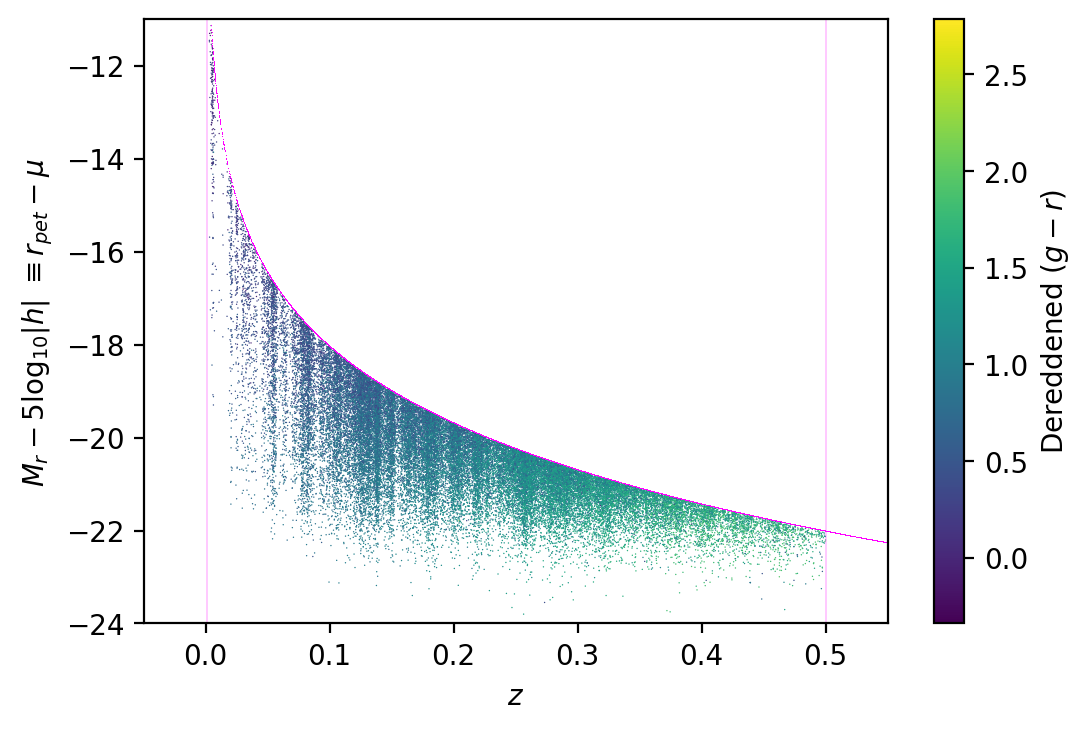

In [77]:
figure(figsize=(6, 4), dpi=200)

pl.scatter(derived['Z'], derived['Mrh'], marker='.', lw=0.0,  c=derived['GMR'], label='BGS OP', s=1)

pl.plot(derived['ZMAX'], derived['Mrh'], marker=',', lw=0.0,  c='magenta', label='zmax loci')

pl.xlabel('$z$')
pl.ylabel('$M_r - 5\log_{10}|h|$ $\equiv r_{pet} - \mu$ ')

pl.xlim(-0.05, 0.55)
pl.ylim( -24., -11.)

# pl.legend(frameon=False, loc=1)

pl.colorbar(label='Dereddened $(g-r)$')

pl.axvline(0.001, c='magenta', lw=0.15)
pl.axvline(0.500, c='magenta', lw=0.15)

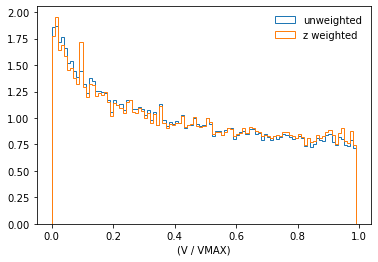

In [86]:
pl.hist(derived['VonVMAX'], bins=np.arange(0.0, 1.0, 0.01), histtype='step', label='unweighted', density=True)
pl.hist(derived['VonVMAX'], weights=derived['BGS_Z_WEIGHT'], bins=np.arange(0.0, 1.0, 0.01), histtype='step', label='z weighted', density=True)

pl.xlabel('(V / VMAX)')

pl.legend(frameon=False, loc=1)

# Done.